In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from subprocess import Popen, PIPE

def surge_exp(E,p,lmbd,E_th):
    x=np.heaviside(E-E_th,1)*(E-E_th)
    return ((e/lmbd)**p)*(x**p)*np.exp(-p*x/lmbd)
    
def surge_pwr(E,p,lmbd,E_th):
    x=np.heaviside(E-E_th,1)*(E-E_th)
    return (lmbd**p)*(p+1)**(p+1)*x/(x+p*lmbd)**(p+1)
    
def Input(Y,m,E_th):
        n=500
    
        f=open("LXCat.txt","w")
        #Elastic
        f.write('----------------------\n')
        f.write('ELASTIC\nSurge\n')
        f.write('1.371541e-4 / mass ratio\n')
        f.write('----------------------\n')
    
        for i in range(n):
            f.write(str(E[i])+' '+str(Y[i,0])+'\n')
            
        #Inelastic
        f.write('----------------------\n')
        f.write('EXCITATION\nSurge\n')
        f.write(str(E_th[2])+' / Thresold Energy\n')
        f.write('1.371541e-4 / mass ratio\n')
        f.write('----------------------\n')
    
        for i in range(n):
            f.write(str(E[i])+' '+str(Y[i,1])+'\n')
    
def ex(grid=100,E_min=1e-3,E_max=1e3,n=1000):
        f=open("ex.dat","w")
        f.write("READCOLLISIONS\n")
        f.write("LXCat.txt\nSurge\n1\n")
        f.write("CONDITIONS\n")
        f.write("1       / Electric field / N (Td)\n")
        f.write("0        / Angular field frequency / N (m3/s)\n")
        f.write("0.        / Cosine of E-B field angle\n")
        f.write("0.       / Gas temperature (K)\n")
        f.write("300.      / Excitation temperature (K)\n")
        f.write("0.        / Transition energy (eV)\n")
        f.write("0.        / Ionization degree\n")
        f.write("1e-6      / Plasma density (1/m3)\n")
        f.write("1.        / Ion charge parameter\n")
        f.write("1.        / Ion/neutral mass ratio\n")
        f.write("1         / e-e momentum effects: 0=No; 1=Yes*\n")
        f.write("1         / Energy sharing: 1=Equal*; 2=One takes all\n")
        f.write("1         / Growth: 1=Temporal*; 2=Spatial; 3=Not included; 4=Grad-n expansion\n")
        f.write("0.        / Maxwellian mean energy (eV) \n")
        f.write(str(grid)+"      / # of grid points\n")
        f.write("0         / Manual grid: 0=No; 1=Linear; 2=Parabolic \n")
        f.write("1000.      / Manual maximum energy (eV)\n")
        f.write("1e-10     / Precision\n")
        f.write("1e-5      / Convergence\n")
        f.write("1000      / Maximum # of iterations\n")
        f.write("1        / Gas composition fractions\n")
        f.write("1         / Normalize composition to unity: 0=No; 1=Yes\n")
        f.write("RUNSERIES\n")
        f.write("1          / Variable: 1=E/N; 2=Mean energy; 3=Maxwellian energy \n")
        f.write(str(E_min)+" "+str(E_max)+"  / Min Max\n")
        f.write(str(n)+"         / Number \n")
        f.write("3          / Type: 1=Linear; 2=Quadratic; 3=Exponential\n")
        f.write("SAVERESULTS\n")
        f.write("Surge.dat        / File \n")
        f.write("3        / Format: 1=Run by run; 2=Combined; 3=E/N; 4=Energy; 5=SIGLO; 6=PLASIMO\n")
        f.write("1        / Conditions: 0=No; 1=Yes\n")
        f.write("1        / Transport coefficients: 0=No; 1=Yes\n")
        f.write("1        / Rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Reverse rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Energy loss coefficients: 0=No; 1=Yes\n")
        f.write("1        / Distribution function: 0=No; 1=Yes \n")
        f.write("0        / Skip failed runs: 0=No; 1=Yes\n")
        f.write("END")
        f.close()
        
def Bolsig():
    t=time.time()
    process = Popen(['./bolsigminus', 'ex.dat'], stdout=PIPE, stderr=PIPE)
    stdout, stderr = process.communicate()
    #print (stdout)
    
def Output(n=1000):
    f=open("Surge.dat","r")
    
    E=np.zeros(n)
    out=np.zeros((n,5))
    for line in f:
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mean energy (eV)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,0] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mobility *N (1/m/V/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,1] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Diffusion coefficient *N (1/m/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,2] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Error code':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,4] = [float(x) for x in l.split()]
    
    out[:,3]=out[:,1]/out[:,2] #Characteristic Energy = Mobility / Diffusion
    
    out[:,1]=out[:,1]*E*1e-21 #Drift Velocity
    out[:,2]=out[:,2]*1e-24 #Diffusion coefficient
    
    if np.sum(out<0)>0:
        plt.loglog(E,out[:,0])
        plt.loglog(E,out[:,1])
        plt.loglog(E,out[:,2])
        plt.loglog(E,out[:,3])
        plt.show()
    
    #print('time:',time.time()-t)
    return out

|

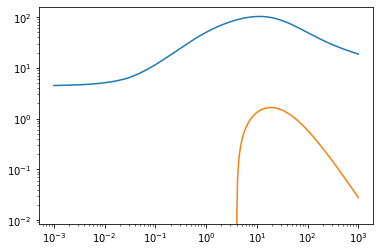

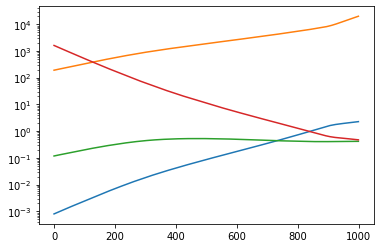

|

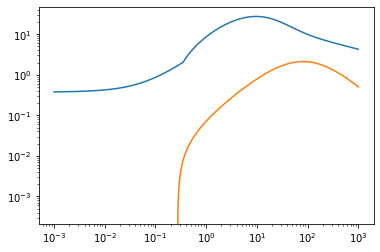

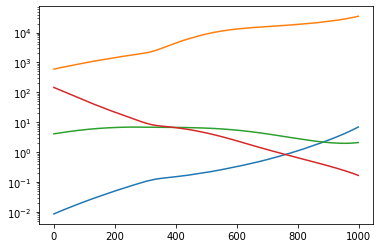

|

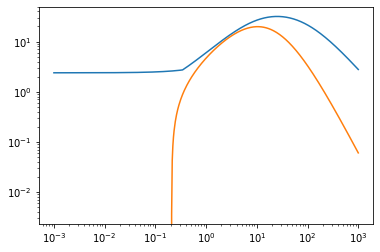

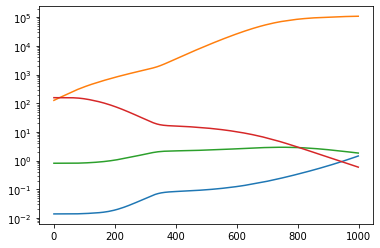

|

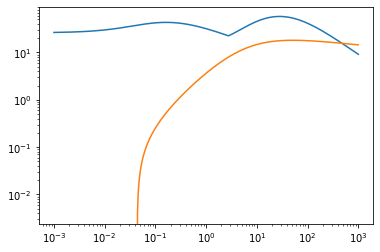

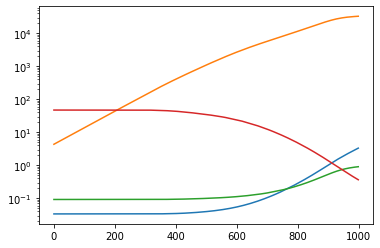

|

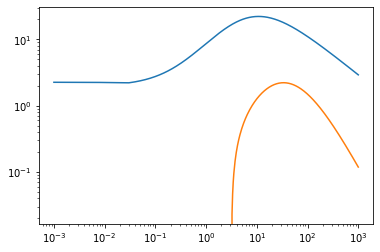

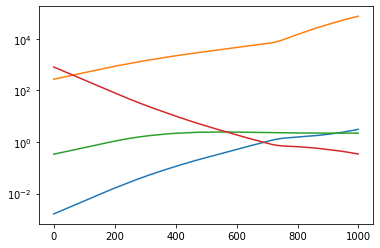

|

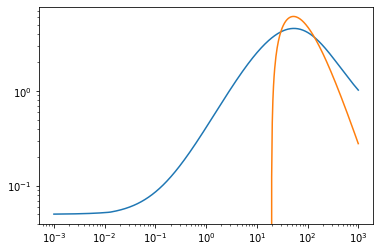

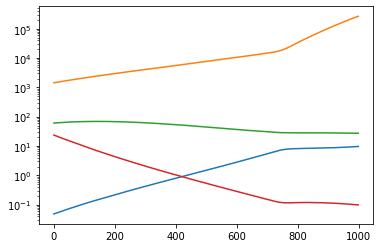

|

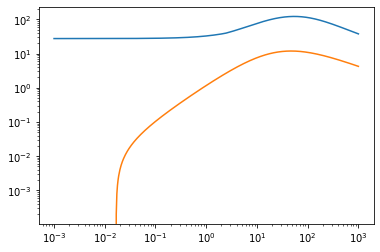

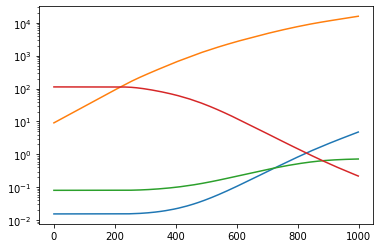

|

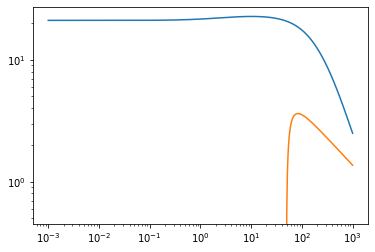

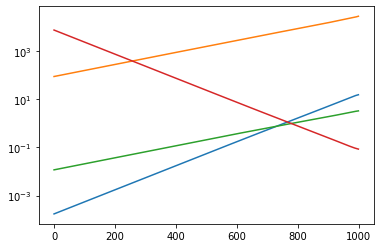

|

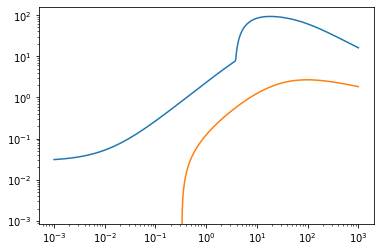

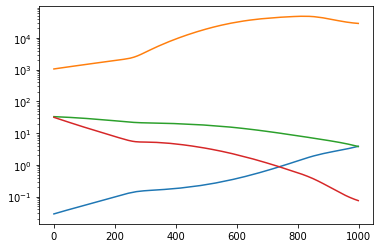

|

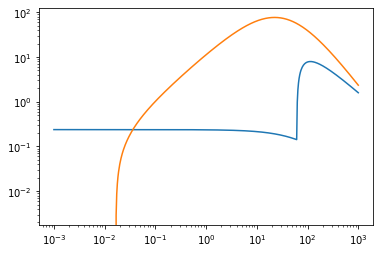

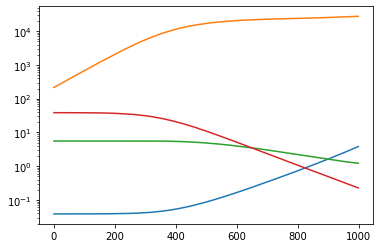

25.60093903541565


In [10]:
#cross=open('Y.csv','wb')
#trans=open('X.csv','wb')
 

n=10
m=3 #no. of Surge functions (elastic:2, inelastic:1)

A=np.zeros((n,m))
A[:,0]=10**(np.random.rand(n)*2) # in range (1 to 100) (Angstrom)^2
A[:,1:]=10**(np.random.rand(n,m-1)*2) # in range (1 to 100) (Angstrom)^2

p=np.zeros((n,m))
p[:,0]=np.random.rand(n)*2.9+0.1  #in (0.1 to 3) 
p[:,1:]=np.random.rand(n,m-1)*1.9+0.1  #in (0.1 to 2) 

lmbd=np.zeros((n,m))
lmbd[:,0]=10**(np.random.rand(n)*4-2) #in (0.01 to 100) (eV)
lmbd[:,1:]=10**(np.random.rand(n,m-1)+1) #in (10 to 100) (eV)

E_th=10**(np.random.rand(n,m)*4-2) #in (0.01 to 100) (eV)
E_th[:,0]=-E_th[:,0] #One of the threshold energy has to be negative for elastic collision.



E=np.logspace(-3,3,500)
Y=np.zeros((n,500,m-1))

for i in range(n):
    for j in range(2): #elastic
        surge=A[i,j]*1e-20*surge_pwr(E,p[i,j],lmbd[i,j],E_th[i,j])
        Y[i,:,0]+=surge
    for j in range(2,m): #inelastic
        surge=A[i,j]*1e-20*surge_pwr(E,p[i,j],lmbd[i,j],E_th[i,j])
        Y[i,:,j-1]=surge
        

err_hist=[]
t=time.time()
for i in range(n):
    Input(Y[i,:,:],m,E_th[i,:])
    ex(grid=100,E_min=1e-3,E_max=1e2,n=1000) #n cannot be more than 1000
    Bolsig()
    X=Output(n=1000)
    print('|',end='')
    err_hist.append(np.sum(X[:,4]))
    if err_hist[i]>300:
        print(A[i,:],p[i,:],lmbd[i,:],np.sum(err_hist[i]),Y[i,499])
    plt.loglog(E,Y[i,:]*1e20)
    plt.show()
    plt.semilogy(X)
    plt.show()
    #X=np.log10(X)
    #np.savetxt(cross,np.reshape(Y[i,:]*1e20,(1,-1)),delimiter=',')
    #np.savetxt(trans,np.reshape(X,(1,-1)),delimiter=',')
print(time.time()-t)
#cross.close()
#trans.close()